<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Параметры-для-запуска" data-toc-modified-id="Параметры-для-запуска-1">Параметры для запуска</a></span></li><li><span><a href="#Считывание-изображения" data-toc-modified-id="Считывание-изображения-2">Считывание изображения</a></span></li><li><span><a href="#Фильтрация-изображения" data-toc-modified-id="Фильтрация-изображения-3">Фильтрация изображения</a></span></li><li><span><a href="#Выделение-сомы" data-toc-modified-id="Выделение-сомы-4">Выделение сомы</a></span></li><li><span><a href="#Определение-центра" data-toc-modified-id="Определение-центра-5">Определение центра</a></span></li><li><span><a href="#Выделение-толстых-отростков" data-toc-modified-id="Выделение-толстых-отростков-6">Выделение толстых отростков</a></span></li><li><span><a href="#Матрица-Гессе" data-toc-modified-id="Матрица-Гессе-7">Матрица Гессе</a></span></li><li><span><a href="#Построение-графа" data-toc-modified-id="Построение-графа-8">Построение графа</a></span><ul class="toc-item"><li><span><a href="#Добавление-точек-сомы-в-граф" data-toc-modified-id="Добавление-точек-сомы-в-граф-8.1">Добавление точек сомы в граф</a></span></li></ul></li><li><span><a href="#Расчет-путей" data-toc-modified-id="Расчет-путей-9">Расчет путей</a></span></li><li><span><a href="#Расчет-встречаемости" data-toc-modified-id="Расчет-встречаемости-10">Расчет встречаемости</a></span></li><li><span><a href="#Фильтрация-точек-по-встречаемости" data-toc-modified-id="Фильтрация-точек-по-встречаемости-11">Фильтрация точек по встречаемости</a></span></li><li><span><a href="#Выделение-тонких-веток" data-toc-modified-id="Выделение-тонких-веток-12">Выделение тонких веток</a></span></li><li><span><a href="#Объединение" data-toc-modified-id="Объединение-13">Объединение</a></span><ul class="toc-item"><li><span><a href="#Выделение-крайних-точек" data-toc-modified-id="Выделение-крайних-точек-13.1">Выделение крайних точек</a></span></li><li><span><a href="#Ближайшие-точки-скелета" data-toc-modified-id="Ближайшие-точки-скелета-13.2">Ближайшие точки скелета</a></span></li><li><span><a href="#Добавление-соединений" data-toc-modified-id="Добавление-соединений-13.3">Добавление соединений</a></span></li></ul></li><li><span><a href="#Многомасштабный-гессиан" data-toc-modified-id="Многомасштабный-гессиан-14">Многомасштабный гессиан</a></span></li></ul></div>

In [1]:
import os
import sys

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt

In [3]:
import cv2
import scipy
from scipy import ndimage as ndi
import numpy as np
import networkx as nx

In [4]:
import napari

In [5]:
from tqdm.auto import tqdm

In [6]:
import ccdb
import astromorpho as astro

Can't load imreg package, affine and homography registrations won't work


/home/levtg/astro-morpho/venv/lib64/python3.10/site-packages/imfun/external/tifffile.py:7261: UserWarning: No module named 'imfun.external._tifffile'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))
/home/levtg/astro-morpho/venv/lib64/python3.10/site-packages/imfun/external/czifile.py:146: UserWarning: ImportError: No module named '_czifile'. Decoding of JXR and JPEG encoded images will not be available. Czifile.pyx can be obtained at http://www.lfd.uci.edu/~gohlke/
  warnings.warn(
2022-05-26 15:21:36.089072: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/levtg/astro-morpho/venv/lib/python3.10/site-packages/cv2/../../lib64:/home/levtg/v3d_external/v3d_main/common_lib/lib/
2022-05-26 15:21:36.089094: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dler

In [7]:
from networx2napari import draw_edges, draw_nodes

In [8]:
def weight_of_arr(a, b):
    dprod = np.einsum('...ij,...ij->...i', a, b)
    norm_a = np.linalg.norm(a, axis=-1)
    norm_b = np.linalg.norm(b, axis=-1)
    cos_dist = np.nan_to_num(dprod / ((norm_a * norm_b)), nan=0)
    cos_dist = 1 - cos_dist
    return np.abs(1 - cos_dist) * np.mean([norm_a, norm_b], axis=0)

In [9]:
def calc_edges(arr1, arr2, index1, index2):
    weights = weight_of_arr(arr1, arr2)
    weight = weights.ravel()
    li = threshold_li(weight)
    idx1 = [tuple(i) for i in index1.reshape((-1, index1.shape[-1]))[weight>li]]
    idx2 = [tuple(i) for i in index2.reshape((-1, index2.shape[-1]))[weight>li]]
    return zip(idx1, idx2, 1 - weight[weight>li])

In [10]:
def count_points_paths(paths):
    acc = {}
    for path in paths:
        for n in path:
            if n in acc.keys():
                acc[n] += 1
            else:
                acc[n] = 1
    return acc

# Параметры для запуска

In [11]:
filename = '/home/levtg/astro-morpho/data/3wk-both1-grn-raw.pic'
verbose = True
sigma = 2

# Set false to start from console
HANDY = True

# Set true to save output
OUT = False

# Считывание изображения

In [12]:
if HANDY:
    filename = '/home/levtg/astro-morpho/data/3wk-ly10-raw.pic'

In [13]:
stack, meta = ccdb.read_pic(filename)
dims = ccdb.get_axes(meta)
dims

[(0.05873016, "Microns'"), (0.05873016, "Microns'"), (0.25, "Microns'")]

In [14]:
if len(dims):
    zoom = dims[0][0]/dims[-1][0]
else:
    zoom = 4

clahe

In [15]:
clahe = cv2.createCLAHE(clipLimit =2.0, tileGridSize=(8,8))

In [16]:
IMG_SHAPE = stack.shape
stack_flat = stack.reshape((IMG_SHAPE[0], -1))
img_flat = clahe.apply(stack_flat)
img = img_flat.reshape(IMG_SHAPE)

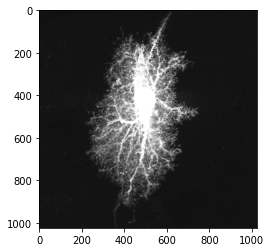

In [17]:
plt.imshow(img.max(0), cmap='gray')

In [18]:
img_noisy = ndi.zoom(img.astype(float),(1, zoom,zoom))

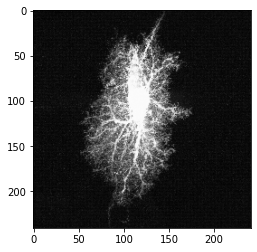

In [19]:
plt.imshow(img_noisy.max(0), cmap='gray')

In [20]:
# napari.view_image(img_noisy)

# Фильтрация изображения

In [21]:
from skimage.filters import threshold_li, threshold_minimum
from skimage.morphology import remove_small_objects

In [22]:
def filter_image(image, filter_func):
    threshold = filter_func(image)
    img_filt = np.where(image > threshold, image, 0)
    binary_clean = remove_small_objects(image >= threshold, 5, connectivity=3)
    return np.where(binary_clean, img_filt, 0)

In [23]:
threshold = lambda x: 187

In [24]:
img_clear = filter_image(img_noisy, threshold_li)
if HANDY:
    pass
#     img_clear = filter_image(img_noisy, threshold_minimum)

In [25]:
final_image = img_clear

In [26]:
w = napari.view_image(final_image, colormap='magenta')

# Выделение сомы

In [27]:
from skimage.morphology import erosion, dilation

In [28]:
to_erose = final_image[:]

In [29]:
for i in range(6):
    to_erose = erosion(to_erose)

In [30]:
eroded = remove_small_objects(to_erose > 0, 5, connectivity=3)

In [31]:
soma_mask = np.where(dilation(eroded), True, False)

In [32]:
if verbose:
    w.add_image(soma_mask, blending='additive', colormap='cyan')

In [33]:
i, j, k = np.indices(final_image.shape)
idx = np.stack((i,j,k), axis=3)

In [34]:
soma = [tuple(i) for i in idx[soma_mask]]

# Определение центра

In [35]:
import itertools as itt

In [36]:
def percentile_rescale(arr, plow=1, phigh=99.5):
    low, high = np.percentile(arr, (plow, phigh))
    if low == high:
        return np.zeros_like(arr)
    else:
        return np.clip((arr-low)/(high-low), 0, 1)

In [37]:
zstack = final_image[:]

In [38]:
%time X = np.array(list(itt.product(*map(range, zstack.shape))))

CPU times: user 1.93 s, sys: 134 ms, total: 2.06 s
Wall time: 2.06 s


In [39]:
weights_s = percentile_rescale(np.ravel(ndi.gaussian_filter(zstack,5))**2,plow=99.5,phigh=99.99)

In [40]:
center = tuple(map(int, np.sum(X*weights_s[:,None],axis=0)/np.sum(weights_s)))
center

(31, 102, 115)

# Выделение толстых отростков

In [41]:
branches = filter_image(img_noisy, threshold_minimum)
img_branch = branches/branches.max()

In [42]:
from skimage.morphology import skeletonize, flood

In [43]:
flood_mask = flood(img_branch > 0, center)
if verbose:
    w.add_image(flood_mask, colormap='red', opacity=0.5)

In [44]:
img = np.where(flood_mask, img_branch, 0)
skeleton = skeletonize(img)
if verbose:
    w.add_image(skeleton, blending='additive', colormap='cyan')

In [45]:
w_branch_mask = skeleton == 255

TEST AREA START

In [46]:
def localize_graph_points(G, point_loc, nodes=None, dist=1):
    if nodes is None:
        nodes = G.nodes()
    node_coords = np.array(nodes.keys())
    node_dists = np.linalg.norm(point_loc-node_coords, axis=-1)
    suit_points = [tuple(n) for n in node_coords[node_dists < dist]]
    return suit_points

In [47]:
def set_graph_area(G, area_mask, out=True, set_name=None):
    coords = np.array(G.nodes())
    node_check = area_mask[coords[:,0], coords[:,1], coords[:,2]]
    selected_nodes = [tuple(n) for n in coords[node_check]]
   
    if set_name is not None:
        nx.set_node_attributes(G, {tuple(n): {'area':set_name} for n in coords[node_check]})
                
    if out:
        return selected_nodes

Нужна функция для выделения сабграфа (библиотечная делает ридонли). Функция ниже из доков. Требует осмысления и доработки.

In [48]:
def create_subgraph(G, nodes):
    # Create a subgraph SG based on a (possibly multigraph) G
    SG = G.__class__()
    SG.add_nodes_from((n, G.nodes[n]) for n in largest_wcc)
    if SG.is_multigraph():
        SG.add_edges_from((n, nbr, key, d)
            for n, nbrs in G.adj.items() if n in largest_wcc
            for nbr, keydict in nbrs.items() if nbr in largest_wcc
            for key, d in keydict.items())
    else:
        SG.add_edges_from((n, nbr, d)
            for n, nbrs in G.adj.items() if n in largest_wcc
            for nbr, d in nbrs.items() if nbr in largest_wcc)
    SG.graph.update(G.graph)
    return SG

In [49]:
# nodes= G3.nodes()
# c = np.array(nodes)
# sc = soma_mask[c[:,0], c[:,1], c[:,2]]
# soma_nodes = [tuple(n) for n in c[sc]]
# G3.remove_nodes_from(soma_nodes)


In [50]:
# Gsub2 = G3.subgraph(points_mean)
# new_nodes = {n:n for n in Gsub2.nodes()}

In [51]:
# Gsub2 = G3.subgraph(soma_nodes)
# new_nodes = {n:n for n in Gsub2.nodes()}
# props = {'weight': 1 - np.array([edgedata["weight"] for _, _, edgedata in Gsub2.edges(data=True)])}
# w.add_shapes(draw_edges(new_nodes, list(Gsub2.edges())), 
#              shape_type='path', 
#              edge_color='weight', 
#              edge_width=0.1, 
#              edge_colormap='inferno', 
#              properties=props)

TEST AREA END

# Матрица Гессе

In [52]:
if HANDY:
    sigma = 1.5

In [53]:
sato, Vf = astro.hessian.sato3d(final_image, sigma, hessian_variant='gradient_of_smoothed', return_vectors=True)

In [54]:
Vfx = Vf[...,0][...,::-1]
V = Vfx[..., 0]
U = Vfx[..., 1]
C = Vfx[..., 2]

In [55]:
lengths = astro.enh.percentile_rescale(sato)**0.5

In [56]:
vectors = np.stack((U*lengths, V*lengths, C*lengths), axis=3)

# Построение графа

In [57]:
crops = [((slice(1, None)), (slice(None, -1))),
         ((slice(1, None), slice(1, None), slice(1, None)), (slice(None, -1), slice(None, -1), slice(None, -1))),
         ((slice(1, None), slice(None, -1), slice(None, -1)), (slice(None, -1), slice(1, None), slice(1, None))),
         ((slice(1, None), slice(1, None)), (slice(None, -1), slice(None, -1))),
         ((slice(1, None), slice(None, -1)), (slice(None, -1), slice(1, None))),
         ((slice(1, None), slice(1, None), slice(None, -1)), (slice(None, -1), slice(None, -1), slice(1, None))),
         ((slice(1, None), slice(None, -1), slice(1, None)), (slice(None, -1), slice(1, None), slice(None, -1))),
         ((slice(1, None), slice(None), slice(None, -1)), (slice(None, -1), slice(None), slice(1, None))),
         ((slice(1, None), slice(None), slice(1, None)), (slice(None, -1), slice(None), slice(None, -1))),
         ((slice(None), slice(1, None), slice(1, None)), (slice(None), slice(None, -1), slice(None, -1))),
         ((slice(None), slice(1, None)), (slice(None), slice(None, -1))),
         ((slice(None), slice(1, None), slice(None, -1)), (slice(None), slice(None, -1), slice(1, None))),
         ((slice(None), slice(None), slice(None, -1)), (slice(None), slice(None), slice(1, None)))]

In [58]:
G3 = nx.Graph()
nodes3 = {}

In [59]:
for crop, acrop in tqdm(crops):
     G3.add_weighted_edges_from(calc_edges(vectors[crop], vectors[acrop], idx[crop], idx[acrop]))

  0%|          | 0/13 [00:00<?, ?it/s]

/tmp/ipykernel_184168/1847692117.py:5: RuntimeWarning: invalid value encountered in true_divide
  cos_dist = np.nan_to_num(dprod / ((norm_a * norm_b)), nan=0)


## Добавление точек сомы в граф

In [65]:
def get_mask_vals(idxs, mask):
    idx_mask = mask[idxs[:,0], idxs[:,1], idxs[:,2]]
    return idxs[idx_mask]

In [68]:
def get_edges(mask, index1, index2, weight):
    idx1 = [tuple(i) for i in get_mask_vals(index1.reshape((-1, index1.shape[-1])), mask)]
    idx2 = [tuple(i) for i in get_mask_vals(index2.reshape((-1, index2.shape[-1])), mask)]
    print(idx1, idx2)
    return zip(idx1, idx2, weight)

In [61]:
Gsoma = nx.Graph()

In [69]:
for crop, acrop in tqdm(crops):
    Gsoma.add_weighted_edges_from(get_edges(soma_mask, idx[crop], idx[acrop], 0.7))

  0%|          | 0/13 [00:00<?, ?it/s]

[(22, 74, 106), (22, 75, 107), (22, 75, 108), (22, 76, 108), (22, 76, 109), (22, 77, 110), (22, 106, 110), (23, 73, 106), (23, 74, 105), (23, 74, 106), (23, 74, 107), (23, 74, 108), (23, 74, 109), (23, 75, 106), (23, 75, 107), (23, 75, 108), (23, 75, 109), (23, 76, 107), (23, 76, 108), (23, 76, 109), (23, 76, 110), (23, 77, 108), (23, 77, 109), (23, 77, 110), (23, 77, 111), (23, 78, 110), (23, 90, 116), (23, 92, 115), (23, 93, 114), (23, 96, 118), (23, 105, 110), (23, 106, 109), (23, 106, 110), (23, 106, 111), (23, 107, 110), (23, 107, 114), (23, 110, 118), (24, 72, 108), (24, 73, 107), (24, 73, 108), (24, 73, 109), (24, 74, 106), (24, 74, 107), (24, 74, 108), (24, 74, 109), (24, 74, 110), (24, 75, 106), (24, 75, 107), (24, 75, 108), (24, 75, 109), (24, 75, 110), (24, 75, 111), (24, 76, 107), (24, 76, 108), (24, 76, 109), (24, 76, 110), (24, 76, 111), (24, 77, 108), (24, 77, 109), (24, 77, 110), (24, 77, 111), (24, 78, 108), (24, 78, 109), (24, 78, 110), (24, 78, 111), (24, 79, 110), (

TypeError: 'float' object is not iterable

In [ ]:
nx.set_edge_attributes(G, 0.7, name='weight')
# nx.set_edge_attributes(G, 'soma', name='area')

In [ ]:
for p1, p2, weight in Gsoma.edges(data=True):
    try:
        old_weight = G3.get_edge_data(p1, p2)['weight']
    except:
        old_weight = 1
    G3.add_edge(p1, p2, weight=min(weight['weight'], old_weight))

In [54]:
nodes3 = {n:n for n in G3.nodes()}

# Расчет путей

In [55]:
%time paths_dict = nx.single_source_dijkstra_path(G3, center)

CPU times: user 8.43 s, sys: 79 ms, total: 8.51 s
Wall time: 8.53 s


In [56]:
paths = list(paths_dict.values())

In [252]:
if OUT:
    np.save('{}_sigma{}_paths_all'.format(os.path.basename(filename), sigma), np.array(paths, dtype=object))

# Расчет встречаемости

In [57]:
points = count_points_paths(paths)

In [ ]:
if OUT:
    np.save('{}_sigma{}_points_count'.format(os.path.basename(filename), sigma), np.array(points, dtype=object))

In [ ]:
if verbose:
    w.add_points(draw_nodes(nodes3, points), size=1, edge_color='transparent', face_color='b', name='count')

In [58]:
count_1 = []
for path in paths:
    count = 0
    for n in path:
        if points[n] == 1:
            count += 1
    count_1.append(count)

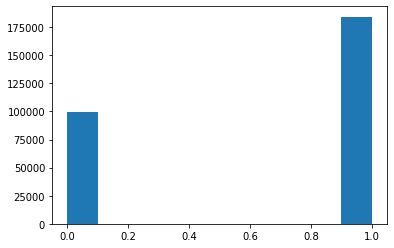

In [59]:
plt.hist(count_1)
plt.show()

In [60]:
to_del = []
for point, count in points.items():
    if count == 1:
        to_del.append(point)

# Фильтрация точек по встречаемости

In [61]:
from copy import copy
points_count = copy(points)

In [62]:
for point in to_del:
    del points_count[point]

In [63]:
sorted(points_count.values())[-20:]

[71783,
 87435,
 87444,
 87587,
 87592,
 87603,
 87612,
 87635,
 99280,
 99329,
 99406,
 99458,
 99466,
 99469,
 99490,
 99493,
 102645,
 174474,
 220982,
 284231]

In [64]:
del points_count[center]

In [ ]:
if verbose:
    w.add_points(draw_nodes(nodes3, points_count), size=1, edge_color='transparent', face_color='r', name='count')

In [65]:
qstack = np.zeros(vectors.shape[:-1])
for loc, val in points_count.items():
    qstack[loc] = np.log(val)

In [66]:
if verbose:
    w.add_image(qstack)

In [67]:
p = np.asarray(list(points_count.keys()))

In [68]:
vals = np.asarray(list(points_count.values()))

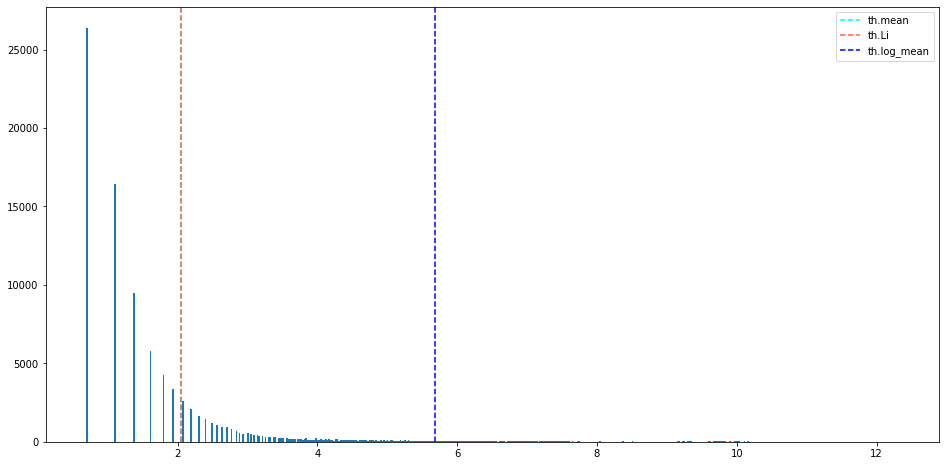

In [69]:
plt.figure(figsize=(16,8))
plt.hist(np.log(vals[vals>1]), bins=500)
#plt.xlim(-10, 100)
plt.axvline(np.mean(np.log(vals)), color='cyan', ls='--', label='th.mean')
plt.axvline(threshold_li(np.log(vals)), color='tomato', ls='--', label='th.Li')
plt.axvline(np.log(np.mean(vals)), color='b', ls='--', label='th.log_mean')
plt.legend()
plt.show()

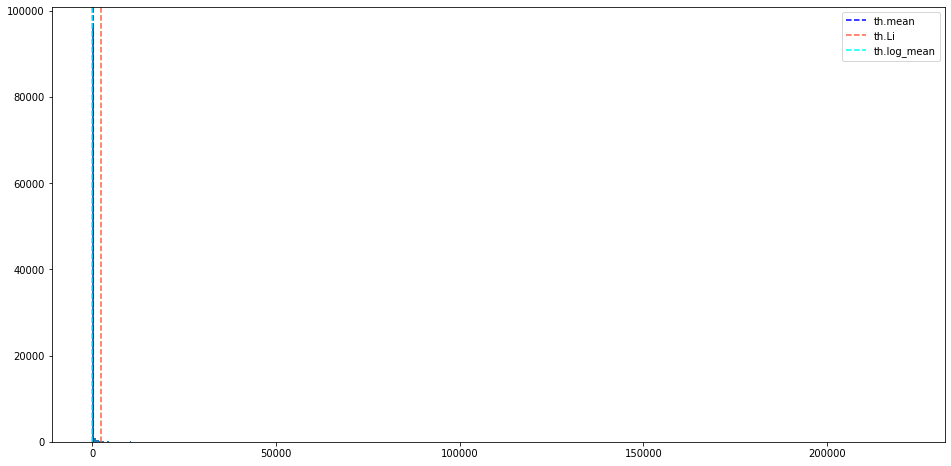

In [70]:
plt.figure(figsize=(16,8))
plt.hist(vals[vals>1], bins=500)
#plt.xlim(-10, 100)
plt.axvline(np.mean(vals), color='b', ls='--', label='th.mean')
plt.axvline(threshold_li(vals), color='tomato', ls='--', label='th.Li')
plt.axvline(np.exp(np.mean(np.log(vals))), color='cyan', ls='--', label='th.log_mean')
plt.legend()
plt.show()

In [71]:
points_mean = [k for k, v in points_count.items() if v > np.mean(vals)]
thr_li = threshold_li(vals)
points_li = [k for k, v in points_count.items() if v > thr_li]
# points_log_mean = [k for k, v in points_count.items() if np.log(v) > np.mean(np.log(vals))]
# points_log_li = [k for k, v in points_count.items() if np.log(v) > threshold_li(np.log(vals))]

In [ ]:
if verbose:
    w.add_points(draw_nodes(nodes3, points_mean), size=1, edge_color='transparent', face_color='c', name='filt mean')
    w.add_points(draw_nodes(nodes3, points_li), size=1, edge_color='transparent', face_color='g', name='filt li')

# Выделение тонких веток

In [72]:
Gsub = G3.subgraph(points_mean)
nodes_sub = {n:n for n in Gsub.nodes()}

In [73]:
props = {'weight': 1 - np.array([edgedata["weight"] for _, _, edgedata in Gsub.edges(data=True)])}

In [74]:
w.add_shapes(draw_edges(nodes_sub, list(Gsub.edges())), shape_type='path', edge_color='weight', edge_width=0.1, edge_colormap='inferno', properties=props)

/home/levtg/astro-morpho/venv/lib64/python3.10/site-packages/numpy/core/numeric.py:2446: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


<Shapes layer 'Shapes' at 0x7fb6c965c8b0>

In [75]:
c = np.array(Gsub.nodes())

In [76]:
graph_mask = np.full(final_image.shape, False)
graph_mask[c[:,0], c[:,1], c[:,2]] = True

In [77]:
th_branch_mask = np.full(final_image.shape, False)
th_branch_mask[c[:,0], c[:,1], c[:,2]] = True
th_branch_mask[flood_mask] = False

In [78]:
th_branch_mask = remove_small_objects(th_branch_mask, 5, connectivity=3)

# Объединение

In [79]:
branch_mask = np.full(final_image.shape, False)
branch_mask[th_branch_mask] = True
branch_mask[w_branch_mask] = True
branch_mask[soma_mask] = True

if verbose:
    bm = napari.view_image(branch_mask)
    bm.add_image(final_image)

file:///home/levtg/astro-morpho/data/pictures_nb/join%20plan.jpg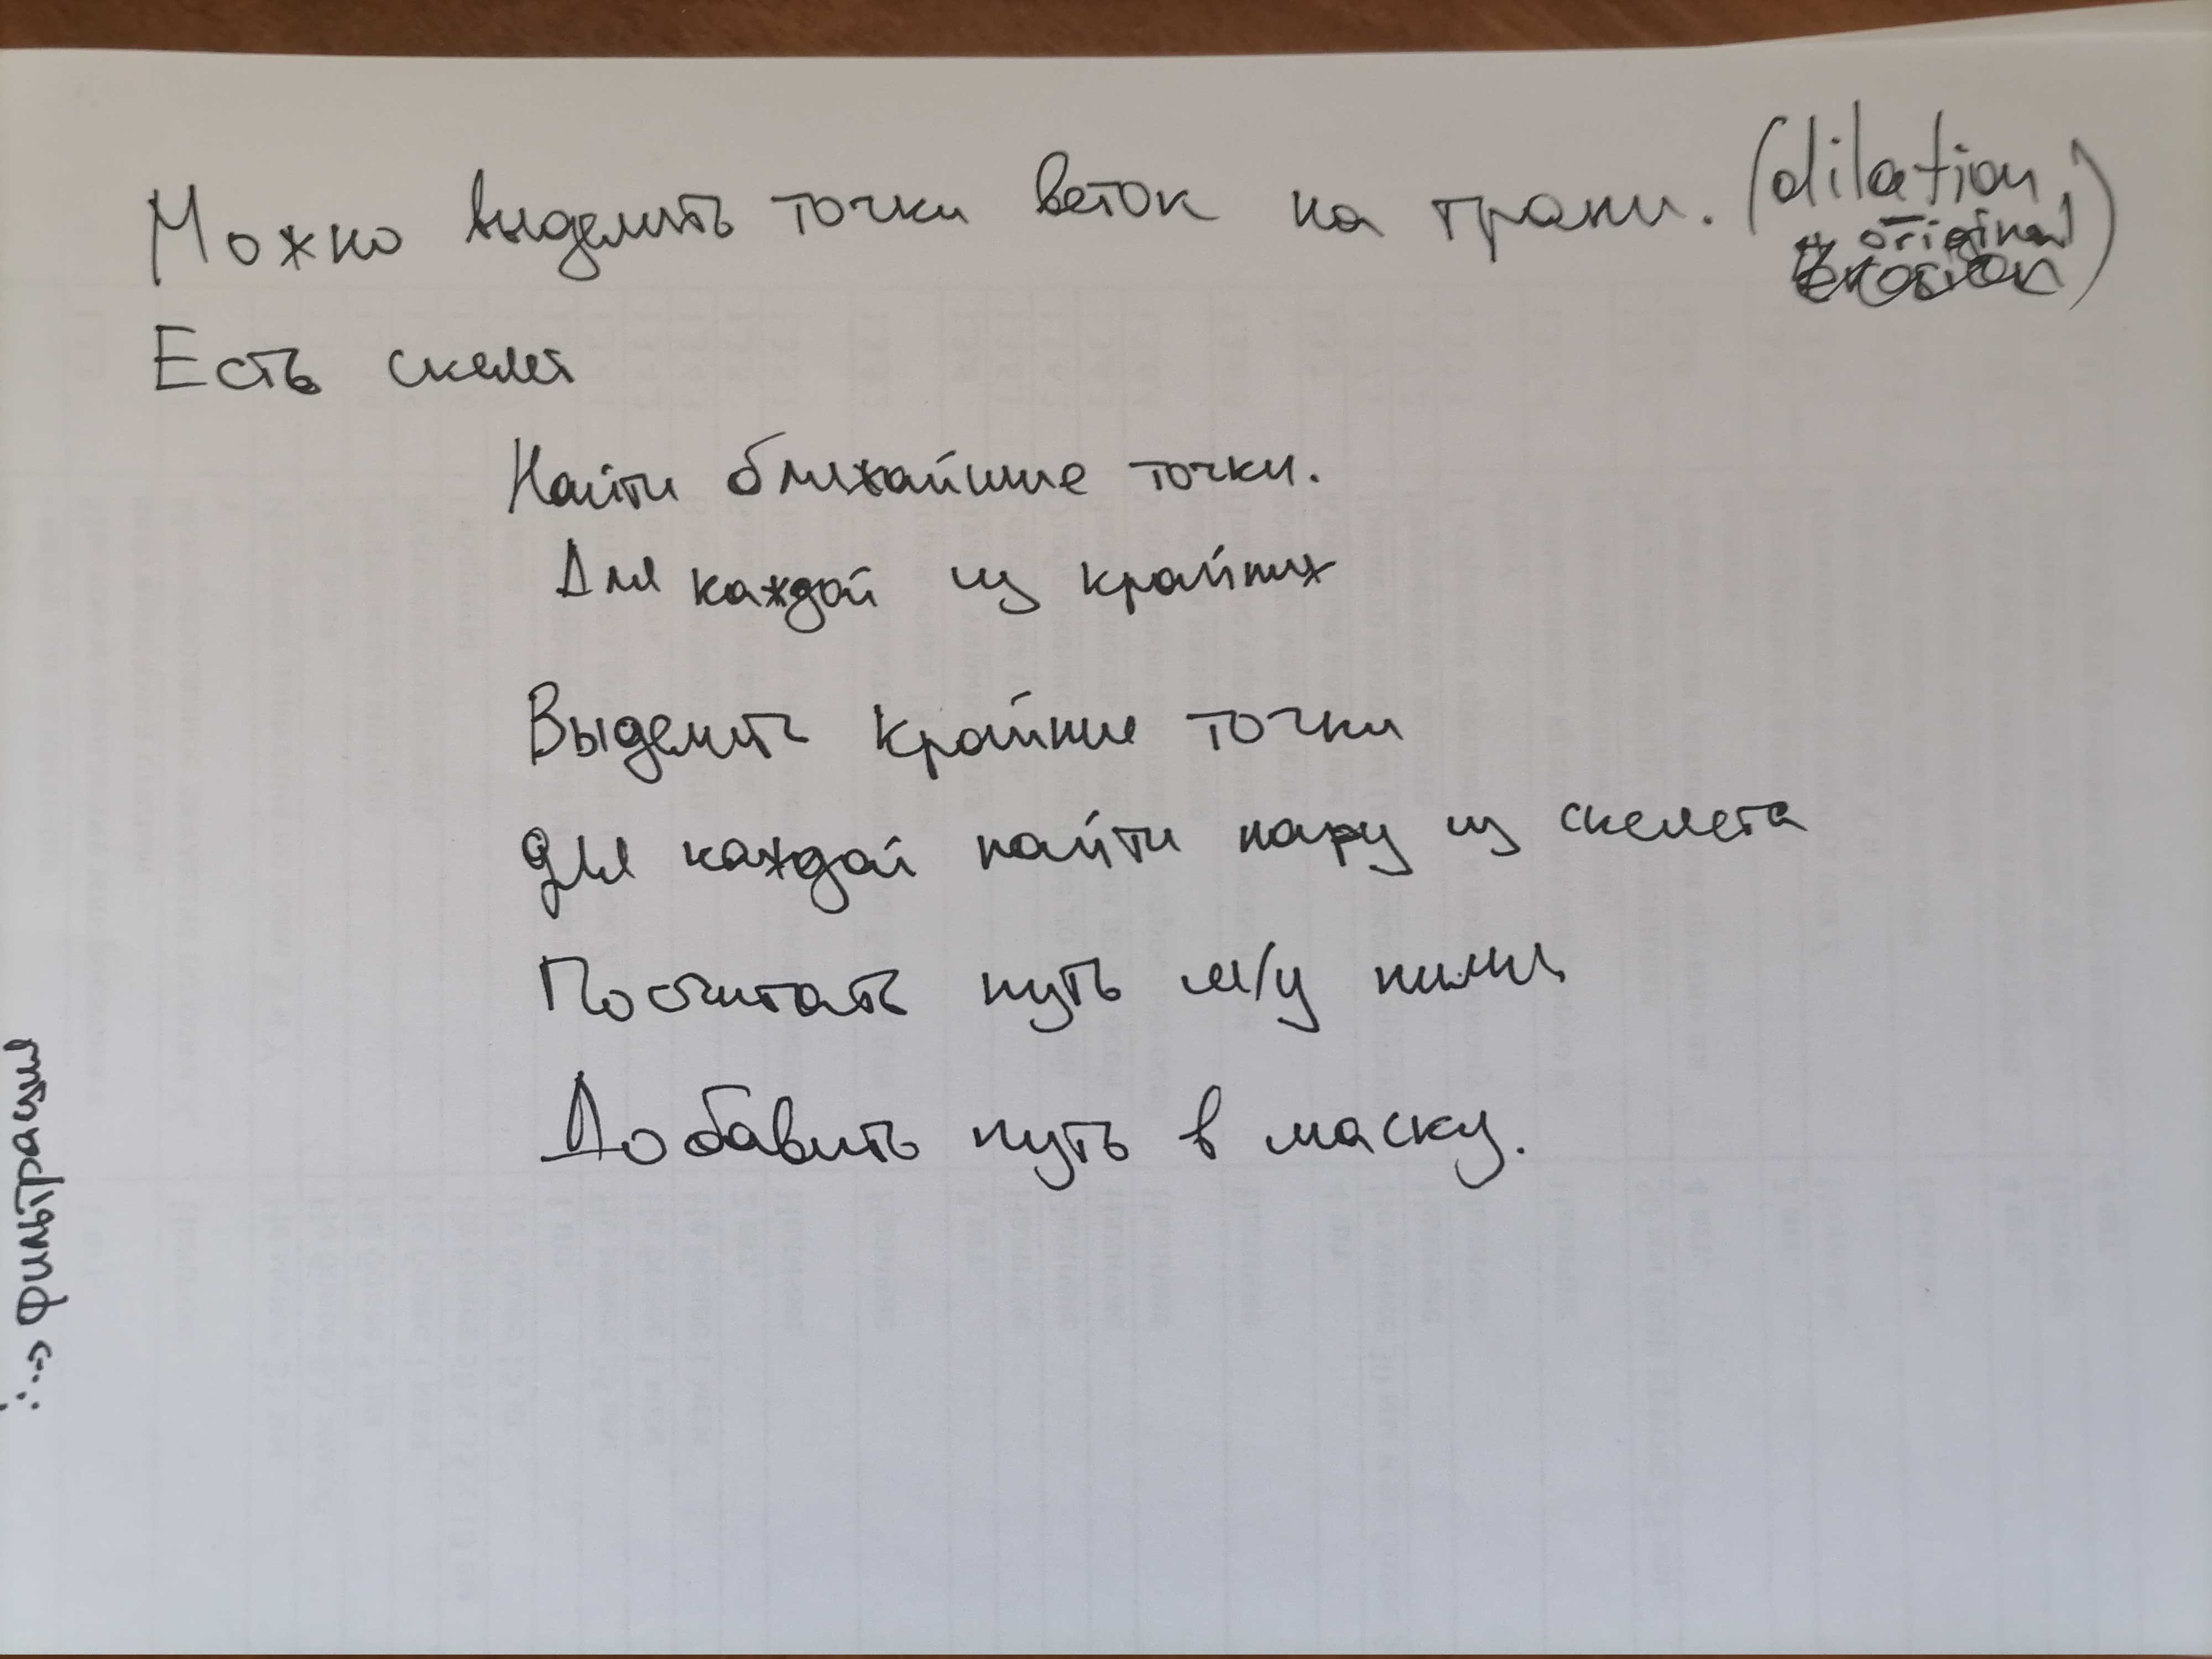

## Выделение крайних точек

In [80]:
from skimage.morphology import cube
edge = dilation(flood_mask, cube(3)) ^ flood_mask
points = edge & th_branch_mask

In [81]:
if verbose:
    bm.add_image(points)

In [82]:
if verbose:
    bm.add_image(w_branch_mask)
    bm.add_image(th_branch_mask)
    bm.add_image(soma_mask)
    bm.add_image(flood_mask)

## Ближайшие точки скелета

In [83]:
points_coords = idx[points]
skelet_coords = idx[w_branch_mask]

In [84]:
points2connect = {}
for point in points_coords:
    point_dists = np.linalg.norm(point - skelet_coords, axis=-1)
    if len(points2connect.keys()) > 0:
        point_n_dists = np.linalg.norm(point - np.array(list(points2connect.keys())), axis=-1)
        if point_n_dists.min() < 1.5:
            continue
    if point_dists.min() > 1.5:
        coord = skelet_coords[point_dists.argmin()]
        points2connect[tuple(point)] = tuple(coord)

In [85]:
print(points_coords.shape, len(points2connect.keys()))

(260, 3) 68


## Добавление соединений

In [86]:
# from networkx.algorithms.shortest_paths.weighted import multi_source_dijkstra
full_mask = branch_mask.copy()
for s, e in points2connect.items():
#     d, p = multi_source_dijkstra(G3, [tuple(n) for n in skelet_coords], s, 'weight')
    path = nx.shortest_path(G3, s, e, 'weight')
    path_coords = np.array(path)
    full_mask[path_coords[:,0], path_coords[:, 1], path_coords[:,2]] = True

# Многомасштабный гессиан

In [ ]:
def vesselness(img, sigma, cc=2., beta=0.5):
    #H = skf.hessian_matrix(img,sigma)
    #Hl = skf.hessian_matrix_eigvals(H)
    Hl = skridges.compute_hessian_eigenvalues(img, sigma)
    sh = img.shape
    v = np.zeros(sh)
    for r in range(sh[0]):
        for c in range(sh[1]):
            for h in range(sh[2]):
                l1,l2,l3 = Hl[0][r,c,h],Hl[1][r,c,h]

                if abs(l2) < abs(l1):
                    l1,l2 = l2,l1
                s = np.sqrt(l1**2 + l2**2 + l3**2)

                if l2 >= 0:
                    v[r,c] = 0
                else:
                    Rb = l1/l2
                    v[r,c] =  (1 - np.exp(-s**2/(2*cc**2)))*np.exp(-(Rb**2)/(2*beta**2))
                    #v[r,c] =  (1 - exp(-(0**2)/(2*c**2)))
                    pass
    return v

def multiscale_vesselness(img, sigma_start, sigma_stop, nlevels=50, reduce_fn=np.max):
    return reduce_fn([vesselness(img, sigma)*sigma**2 for sigma in np.linspace(sigma_start,sigma_stop, nlevels)],0)
